# Short Analysis of Zeroth-Order Frank-Wolfe Variants [Sahu et al] on Black Box settings

To insert a mathematical formula we use the dollar symbol, as follows: <br>
Euler's identity: $ e^{i \pi} + 1 = 0 $
To isolate and center the formulas and enter in math display mode, we use 2 dollars symbol:
$$
...
$$
Euler's identity: $$ e^{i \pi} + 1 = 0 $$

In [1]:
import numpy as np
from scipy import sparse
import pylab as plt
from sklearn import datasets
from scipy.optimize import linprog

  (0, 0)	615.3251790206386


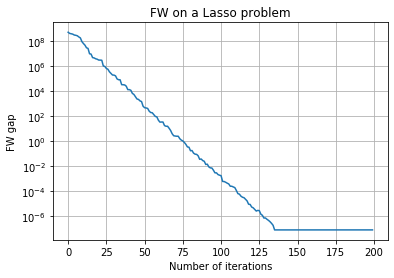

Sparsity of solution: 0.11%


In [7]:
'''from Fabian Pedregosa'''
def FW(alpha, max_iter=200, tol=1e-8):
    # .. initial estimate, could be any feasible point ..
    x_t = sparse.dok_matrix((n_features, 1))
    trace = []  # to keep track of the gap

    # .. some quantities can be precomputed ..
    Atb = A.T.dot(b)
    for it in range(max_iter):
        # .. compute gradient. Slightly more involved than usual because ..
        # .. of the use of sparse matrices ..
        Ax = x_t.T.dot(A.T).ravel()
        grad = (A.T.dot(Ax) - Atb)
        # .. the LMO results in a vector that is zero everywhere except for ..
        # .. a single index. Of this vector we only store its index and magnitude ..
        idx_oracle = np.argmax(np.abs(grad))
        mag_oracle = alpha * np.sign(-grad[idx_oracle])
        g_t = x_t.T.dot(grad).ravel() - grad[idx_oracle] * mag_oracle
        trace.append(g_t)
        if g_t <= tol:
            break
        q_t = A[:, idx_oracle] * mag_oracle - Ax
        step_size = min(q_t.dot(b - Ax) / q_t.dot(q_t), 1.)
        x_t = (1. - step_size) * x_t
        x_t[idx_oracle] = x_t[idx_oracle] + step_size * mag_oracle
    return x_t, np.array(trace)

n_samples, n_features = 1000, 10000
#n_samples, n_features = 100, 1000
A, b = datasets.make_regression(n_samples, n_features)
# .. plot evolution of FW gap ..
sol, trace = FW(.5 * n_features)
plt.plot(trace)
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('FW gap')
plt.title('FW on a Lasso problem')
plt.grid()
plt.show()

sparsity = np.mean(sol.toarray().ravel() != 0)
print('Sparsity of solution: %s%%' % (sparsity * 100))

In [71]:
'''Linear Programming'''
# f(x0,x1) = -x0 + 4x1
f = lambda x: -x[0] + 4*x[1]
c = np.array([-1, 4])
A = [[-3, 1], [1, 2]]
b = [6, 4]

#A = np.array([[-3, 1]])
#b = 6

x0_bounds = (None, None)
x1_bounds = (-3, None)
res = linprog(-c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds]) #there is also A_eq and b_eq which is Ax = b constraints
print(res)
print(f(res["x"]))
#print(linear_program_oracle(c, A, b, [(None, None), (-3, None)]))

     con: array([], dtype=float64)
     fun: -11.428571428000076
 message: 'Optimization terminated successfully.'
     nit: 4
   slack: array([1.9874058e-10, 2.5518343e-10])
  status: 0
 success: True
       x: array([-1.14285714,  2.57142857])
11.428571428000076


### Helper Functions

In [3]:
'''Helper functions, for gradients, oracles, etc'''
def grad_KWSA(F, x, c, d, *f_args):
    '''
    f_args is the arguments of F(.), used if there are complicated functions which reqiures more parameter than just x 
    '''
    grad = 0
    e = np.zeros(d)
    for i in range(d):
        e[i] = 1 #cb-vector
        grad += ((F(x + c*e, *f_args) - F(x, *f_args))/c)*e #calculate the gradient
        e[i] = 0 #reset cb-vector
    return grad

def grad_RDSA(F, x, c, d, *f_args):
    z = np.random.normal(0, 1, size=(d)) #mean = 0, std = 1
    grad = ((F(x + c*z, *f_args) - F(x, *f_args))/c)*z
    return grad

def grad_IRDSA(F, x, c, d, m=5, *f_args):
    grad = 0
    for i in range(m):
        z = np.random.normal(0, 1, size=(d)) #mean = 0, std = 1
        grad += ((F(x + c*z, *f_args) - F(x, *f_args))/c)*z
    return grad/m

def linear_program_oracle(coef, A_ub, b_ub, bounds):
    '''
    f(x) = c^Tx
    Ax <= b
    x within bounds 
    coef = [c_x0, c_x1, ....] coefficient of the equation
    A = [[a0_x0, a0_x1, ...],[a1_x0, a1_x1, ...]] ineq constraint matrix
    b = [b0, b1, ....] ineq constraint vector
    bounds = [(lb_x0, ub_x0), (lb_x1, ub_x1),....]
    '''
    res = linprog(coef, A_ub=A_ub, b_ub=b_ub, bounds=bounds)
    return res["x"] 

# gradient test:
'''
f = lambda x: x[0]**2 + x[1]**2
c = 1e-10
x = np.array([1,2])
'''
f = lambda x: x[0]**4 - 32*x[0] + x[1]**2 - 8*x[1]
c = 1e-10
x = np.array([0,0])
print("KWSA", grad_KWSA(f, x, c, len(x)))
print("RDSA", grad_RDSA(f, x, c, len(x)))
print("IRDSA", grad_IRDSA(f, x, c, len(x)))
x = np.array([2,4]) #x = (2,4) is the global minimum, hence gradient = 0
print("KWSA", grad_KWSA(f, x, c, len(x)))
print("RDSA", grad_RDSA(f, x, c, len(x)))
print("IRDSA", grad_IRDSA(f, x, c, len(x)))



KWSA [-32.  -8.]
RDSA [ 0.00561439 -0.27489941]
IRDSA [-23.33818602   3.44828786]
KWSA [0. 0.]
RDSA [-0. -0.]
IRDSA [0. 0.]


### Franke Wolfe Algorithm and its variants from [Sahu et al] paper

In [4]:
'''Standard frank wolfe algorfithm'''
def frank_wolfe(F, x, LPO_var, alpha=0.1, max_iter=200, *f_args):
    '''
    F = f(x)
    x = input vector or init starting point
    LPO_var = {A, b, bounds}, the constraints and bounds
    f_args is the arguments of F(.), used if there are complicated functions which reqiures more parameter than just x 
    '''
    A = LPO_var["A"]; b = LPO_var["b"]; bounds = LPO_var["bounds"]
    dim = len(x)
    x_out = np.copy(x) #so that the global input x wont be changed
    for i in range(max_iter):
        grad = grad_KWSA(F, x_out, 1e-10, dim, *f_args)
        v = linear_program_oracle(grad, A, b, bounds)
        x_out += alpha*(v - x_out)
    return x_out

def frank_wolfe_away(F, x, LPO_var, alpha=0.1, max_iter=200, *f_args):
    '''
    away version of Frank Wolfe Algorithm
    F = f(x)
    x = input vector or init starting point
    LPO_var = {A, b, bounds}, the constraints and bounds
    '''
    A = LPO_var["A"]; b = LPO_var["b"]; bounds = LPO_var["bounds"]
    dim = len(x)
    alpha_bar = 0 #placeholder
    x_out = np.copy(x)
    for i in range(max_iter):
        grad = grad_KWSA(F, x_out, 1e-10, dim, *f_args)
        v_FW = linear_program_oracle(grad, A, b, bounds)
        v_AS = linear_program_oracle(-grad, A, b, bounds) #away step
        d_FW = v_FW - x_out; d_AS = x_out - v_AS
        grad_FW = np.dot(grad, d_FW); grad_AS = np.dot(grad, d_AS)
        if grad_FW <= grad_AS:
            d = d_FW
            alpha_bar = 1
        else:
            d = d_AS
            alpha_bar = 1 #temporary
        x_out += alpha*d
    return x_out
    
    
'''Zeroth Order Frank Wolfe Algorithms [Sahu et al]'''
'''Stochastic Gradient Free Frank Wolfe - Convex'''
def SGF_frank_wolfe_cvx(F, x, LPO_var, max_iter=200, m=10, mode="KWSA", *f_args):
    '''
    F = f(x)
    x = input vector or init starting point
    LPO_var = {A, b, bounds}, the constraints and bounds
    '''
    A = LPO_var["A"]; b = LPO_var["b"]; bounds = LPO_var["bounds"]
    dim = len(x)
    x_out = np.copy(x)
    t = np.arange(max_iter) # sequence of t = 0,1,....max_iter
    gamma = 2/(t + 8) # initialize gamma sequences
    # rho and c sequences:
    rho = c = None
    if mode == "KWSA":
        rho = 4/((t+8)**(2/3))
        c = 2/(dim**(1/2) * ((t + 8)**(1/3)))
    elif mode == "IRDSA":
        rho = 4/(((1 + (dim/m))**(1/3)) * ((t+8)**(2/3)))
        c = 2*np.sqrt(m)/(dim**(3/2) * (t+8)**(1/3))
    elif mode == "RDSA":
        rho = 4/(dim**(1/3) * (t+8)**(2/3))
        c = 2/(dim**(3/2) * (t+8)**(1/3))
    d = np.zeros(dim) #initial value d_0 = 0
    x_mean = 0 #for xT
    for i in t: #loop
        grad = 0 #placeholder
        if mode == "KWSA":
            grad = grad_KWSA(F, x_out, c[i], dim, *f_args)
        elif mode == "IRDSA":
            grad = grad_IRDSA(F, x_out, c[i], dim, m, *f_args)
        elif mode == "RDSA":
            grad = grad_RDSA(F, x_out, c[i], dim, *f_args)
        d = (1-rho[i])*d + rho[i]*grad #used for linear programming oracle (LPO)
        v = linear_program_oracle(d, A, b, bounds) ### LPO
        x_out = (1-gamma[i])*x_out + gamma[i]*v
        x_mean += x_out
    x_mean /= max_iter #(sum of x)/T
    return x_mean

'''Stochastic Gradient Free Frank Wolfe - NonConvex'''
def SGF_frank_wolfe_noncvx(F, x, LPO_var, max_iter=200, m=10, *f_args):
    '''
    F = f(x)
    x = input vector or init starting point
    LPO_var = {A, b, bounds}, the constraints and bounds
    '''
    A = LPO_var["A"]; b = LPO_var["b"]; bounds = LPO_var["bounds"]
    dim = len(x)
    x_out = np.copy(x)
    t = np.arange(max_iter) # sequence of t = 0,1,....max_iter
    gamma = 1/(max_iter**(3/4)) # initialize gamma sequences
    # rho and c sequences:
    rho = 4/((1+dim/m)**(1/3) * (t+8)**(2/3))
    c = 2*np.sqrt(m)/(dim**(3/2) * (t+8)**(1/3))
    d = np.zeros(dim) #initial value d_0 = 0
    for i in t: #loop
        grad = grad_IRDSA(F, x_out, c[i], dim, m, *f_args)
        d = (1-rho[i])*d + rho[i]*grad #used for linear programming oracle (LPO)
        v = linear_program_oracle(d, A, b, bounds) ### LPO
        x_out = (1-gamma)*x_out + gamma*v
    return x_out

### Testing Ground

<br>
<li>Simple function for testing <br>
$x^2 + y^2 + z^2$ <br>
$-1 \leq (x,y,z) \leq 1$ <br>
minimizer value:  $F(0,0,0) = 0$

In [118]:
f = lambda x: np.sum(x**2)
x = np.array([1., -1., 1.]) #random x0 within feasible reigon
A = None
b = None
bounds = [(-1, 1)]*len(x)
LPO_var = {"A":A, "b":b, "bounds":bounds}
m=3 #for IRDSA gradient

x_out = frank_wolfe(f, x, LPO_var, max_iter=200)
print("{min x, F(x)} of Standard Frank Wolfe =", x_out, f(x_out))
x_out = frank_wolfe_away(f, x, LPO_var, max_iter=200)
print("{min x, F(x)} of Frank Wolfe Away =", x_out, f(x_out))
x_out = SGF_frank_wolfe_cvx(f, x, LPO_var, max_iter=200, m=m, mode="IRDSA") #looks like m corresponds to the dimension size of the problem to be more accurate
print("{min x, F(x)} of SGF Cvx Frank Wolfe =", x_out, f(x_out))
x_out = SGF_frank_wolfe_noncvx(f, x, LPO_var, max_iter=200, m=m)
print("{min x, F(x)} of SGF Non-Cvx Frank Wolfe =", x_out, f(x_out))

{min x, F(x)} of Standard Frank Wolfe = [ 0.05263158 -0.05263158  0.05263158] 0.008310249311776426
{min x, F(x)} of Frank Wolfe Away = [ 0.05263158 -0.05263158  0.05263158] 0.008310249311776426
{min x, F(x)} of SGF Cvx Frank Wolfe = [ 0.01864734 -0.05487923 -0.00125604] 0.0033610305958132088
{min x, F(x)} of SGF Non-Cvx Frank Wolfe = [-0.13396247  0.00948164 -0.0383157 ] 0.019503938360854525


<li>Maximization test<br>
$F(x,y,z) = x^2 + y^2 + z^2$ <br>
$-1 \leq (x,y,z) \leq 1$ <br>
the combinations of $\{-1,1\} \in \mathbb{Z}^3$ are the max values, e.g: $F(-1,1,1) = -3,\quad f = -F = 3$ <br>

In [119]:
'''

'''
f = lambda x: -np.sum(x**2)
x = np.array([0., 0., 0.]) #random x0 within feasible reigon
A = None
b = None
bounds = [(-1, 1)]*len(x)
LPO_var = {"A":A, "b":b, "bounds":bounds}
m=3 #for IRDSA gradient

x_out = frank_wolfe(f, x, LPO_var, max_iter=200)
print("{min x, F(x)} of Standard Frank Wolfe =", x_out, -f(x_out))
x_out = frank_wolfe_away(f, x, LPO_var, max_iter=200)
print("{min x, F(x)} of Frank Wolfe Away =", x_out, -f(x_out))
x_out = SGF_frank_wolfe_cvx(f, x, LPO_var, max_iter=200, m=m, mode="IRDSA") #looks like m corresponds to the dimension size of the problem to be more accurate
print("{min x, F(x)} of SGF Cvx Frank Wolfe =", x_out, -f(x_out))
x_out = SGF_frank_wolfe_noncvx(f, x, LPO_var, max_iter=200, m=m)
print("{min x, F(x)} of SGF Non-Cvx Frank Wolfe =", x_out, -f(x_out))

{min x, F(x)} of Standard Frank Wolfe = [1. 1. 1.] 2.9999999957669528
{min x, F(x)} of Frank Wolfe Away = [842333.73448923 842333.73448923 842335.23367636] 2128580886409.752
{min x, F(x)} of SGF Cvx Frank Wolfe = [ 0.97101449  0.82173913 -0.7857971 ] 2.2356014282713703
{min x, F(x)} of SGF Non-Cvx Frank Wolfe = [0.97650838 0.97563416 0.97183358] 2.8498911184981144


<li>Function from: http://www.math.udel.edu/~angell/Opt/FW.pdf <br>
minimzer value: $ F(1,695, 1,914) = -57.63$

In [237]:
f = lambda x: x[0]**4 - 32*x[0] + x[1]**2 - 8*x[1]
x = np.array([0., 0.])
A = [[1, -1], [3, 1]]
b = [1, 7]
bounds = [(0, None), (0, None)]
LPO_var = {"A":A, "b":b, "bounds":bounds}
m=5 #for IRDSA gradient
x_out = frank_wolfe(f, x, LPO_var)
print("{min x, F(x)} of Standard Frank Wolfe =", x_out, f(x_out))
x_out = frank_wolfe_away(f, x, LPO_var, max_iter=200)
print("{min x, F(x)} of Frank Wolfe Away =", x_out, f(x_out))
x_out = SGF_frank_wolfe_cvx(f, x, LPO_var, max_iter=200, m=m, mode="IRDSA") #looks like m corresponds to the dimension size of the problem to be more accurate
print("{min x, F(x)} of SGF Cvx Frank Wolfe =", x_out, f(x_out))
x_out = SGF_frank_wolfe_noncvx(f, x, LPO_var, max_iter=200, m=m)
print("{min x, F(x)} of SGF Non-Cvx Frank Wolfe =", x_out, f(x_out))

{min x, F(x)} of Standard Frank Wolfe = [1.582 2.253] -57.31468003018529
{min x, F(x)} of Frank Wolfe Away = [2.178 3.739] -63.12670634345123
{min x, F(x)} of SGF Cvx Frank Wolfe = [1.449 2.352] -55.23591041598563
{min x, F(x)} of SGF Non-Cvx Frank Wolfe = [1.549 2.195] -56.55772389787758


<li> Regression test, treated as blackbox function.<br>
$\frac{1}{2}||Ax - b||^2_2$ <br>
$||x||_1 \leq \alpha$

In [5]:
#Regression test, treated as black box
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
n_samples = 100; n_features = 100 #A is n_samples x n_features matrix, x is the variable to be optimized, b is the target
A, b, coef = datasets.make_regression(n_samples, n_features, coef=True, random_state=0) #coef is the optimizer value
f = lambda x,A,b: 0.5*np.square(np.linalg.norm(np.dot(A,x) - b))
#f = lambda x,A,b: (0.5/b.shape[0])*np.square(np.linalg.norm(np.dot(A,x) - b)) + np.linalg.norm(x,1)
#print("optimal coefficients = ",coef)
print("optimal function value (residual) = ", f(coef, A, b)) #the optimal value should be near 0
A_ub = np.ones((1,n_features)) #L1 norm of x is <= 0.5*n_features
b_ub = 0.5*n_features
#A_ub = None
#b_ub = None

'''
#gradient test:
#print("KWSA",grad_KWSA(f, np.zeros(n_features), 1e-10, n_features, A,b))
#print("RDSA",grad_KWSA(f, np.zeros(n_features), 1e-10, n_features, A,b))
#print("IRDSA",grad_IRDSA(f, np.zeros(n_features), 1e-10, n_features, 5, A,b))
'''


LPO_var = {"A":A_ub, "b":b_ub, "bounds":np.array([[None, None]]*n_features)}
m=6
x = np.random.normal(0, 1, size=(n_features))
x_out = frank_wolfe(f, x, LPO_var, 0.1, 200, A, b)
#print("x of Standard Frank Wolfe =", x_out)
print("f(x) of Standard Frank Wolfe =", f(x_out, A, b))
print("||coef - x_out|| =", np.linalg.norm(coef-x_out))
x_out = SGF_frank_wolfe_noncvx(f, x, LPO_var, 200, m, A, b)
#print("x of SGF Non-Cvx FW =", x_out)
print("f(x) of SGF Non-Cvx FW =", f(x_out, A, b))
print("||coef - x_out|| =", np.linalg.norm(coef-x_out))

# actual lasso fit:
from sklearn.linear_model import Lasso
alpha=1
dense_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
dense_lasso.fit(A, b)
print("f(lasso_coef) =", f(dense_lasso.coef_,A,b))
print("||coef-lasso_coef|| =", np.linalg.norm(coef-dense_lasso.coef_))

optimal function value (residual) =  1.5450629689658737e-26
f(x) of Standard Frank Wolfe = 605575.647055823
||coef - x_out|| = 126.42898810755354
f(x) of SGF Non-Cvx FW = 633214.47815463
||coef - x_out|| = 128.89743769100548
f(lasso_coef) = 612.388767301812
||coef-lasso_coef|| = 4.1026964337542315


In [138]:
import cvxpy as cp
# Generate a random non-trivial linear program.
m = 15
n = 10
np.random.seed(1)
s0 = np.random.randn(m)
lamb0 = np.maximum(-s0, 0)
s0 = np.maximum(s0, 0)
x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A @ x0 + s0
c = -A.T @ lamb0

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(c.T@x),
                 [A @ x <= b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)


The optimal value is -15.220912605552863
A solution x is
[-1.10133381 -0.16360111 -0.89734939  0.03216603  0.6069123  -1.12687348
  1.12967856  0.88176638  0.49075229  0.8984822 ]
A dual solution is
[6.98805172e-10 6.11756416e-01 5.28171747e-01 1.07296862e+00
 3.93759300e-09 2.30153870e+00 4.25704434e-10 7.61206896e-01
 8.36906030e-09 2.49370377e-01 1.30187120e-09 2.06014070e+00
 3.22417207e-01 3.84054343e-01 1.59493839e-09]
